In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard.notebook

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# set up tensorboard log directory
logdir="tf_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(logdir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# need the following to successfully run. 
# Otherwise there will be cuDNN error in training 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()

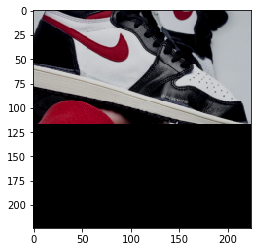

In [23]:
import skimage
import random
import tensorflow_addons as tfa

# define dataloader and preprocessing
def load_and_preprocess_image_train(path):
    image = tf.io.read_file(path)
    return preprocess_image(image, random_rotate=True)

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image, random_rotate=False)

# the following does not work with eager execution
def preprocess_image(image, random_rotate=False, rotate_range=30):
    image = tf.image.decode_jpeg(image, channels=3)
    image = image/255  # normalize to [0,1] range    
    image = tf.image.resize_with_pad(image, 256, 256)
    
#     # tf2.0 does not have tf.contrib which contains random rotation
#     # Was able to find alternative in tensorfow_addons
#     # But there is ongoing issue with rotate: https://github.com/tensorflow/addons/issues/94
#     # The following causes training to be slower - almost doubles the time
#     # I suspect the addons are still buggy and not optimized with the rest of tf package
    if random_rotate:
        rotate_angle = tf.random.uniform(shape=[1], minval=-rotate_range/180*3.14, maxval=rotate_range/180*3.14)
        rot_transform = tfa.image.transform_ops.angles_to_projective_transforms(rotate_angle, 256, 256)
        image = tfa.image.transform(image, rot_transform)
    
    image = tf.image.random_crop(image, (224, 224, 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.clip_by_value(image, 0, 1)
    # tensorflow2.0 does not have tf.conrib.image.rotate()
#     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
    return image

# # define dataloader and preprocessing
# def load_and_preprocess_image(path):
#     image = tf.io.read_file(path)
#     return preprocess_image(image)

# # the following does not work with eager execution
# def preprocess_image(image):
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = image/255  # normalize to [0,1] range
#     # randomly rotate image for data augmentation
#     rotate_range=30
#     rot_angle = random.randint(-rotate_range, rotate_range)
#     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
#     image = tf.image.resize_with_pad(image, 256, 256)
#     image = tf.image.random_crop(image, (224, 224, 3))
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, 0.3)
#     image = tf.image.random_contrast(image, 0.7, 1.3)
#     image = tf.image.random_saturation(image, 0.7, 1.3)
#     # tensorflow2.0 does not have tf.conrib.image.rotate()
# #     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
#     return image

# def load_and_preprocess_image(path):
#     return preprocess_image(path)
# def preprocess_image(image):
#     image = skimage.io.imread(image)
# #     image = tf.image.decode_jpeg(image, channels=3)
#     image = image/255  # normalize to [0,1] range
#     # randomly rotate image for data augmentation
# #     print(image)
#     rotate_range=30
#     rot_angle = random.randint(-rotate_range, rotate_range)
#     image = skimage.transform.rotate(image, rot_angle)
#     image = tf.convert_to_tensor(image)
#     image = tf.image.resize_with_pad(image, 256, 256)
#     image = tf.image.random_crop(image, (224, 224, 3))
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, 0.3)
#     image = tf.image.random_contrast(image, 0.7, 1.3)
#     image = tf.image.random_saturation(image, 0.7, 1.3)
#     # tensorflow2.0 does not have tf.conrib.image.rotate()
# #     image = tf.convert_to_tensor(skimage.transform.rotate(image.numpy(), rot_angle))
#     return image

path = "/home/nan/sneaker_ai/screened_data/air_jordan_1/air_jordan_1_362.png"
plt.imshow(load_and_preprocess_image(path))

In [ ]:
# tf.random.set_random_seed(1234)
# random.seed(1234)

/home/nan/sneaker_ai/screened_data/air_jordan_19/air_jordan_19_251.png


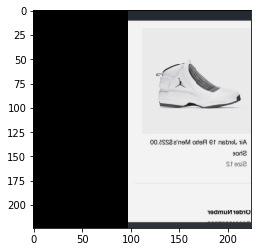

In [4]:
# test random data loaders
train_df = pd.read_csv("train_df.csv")
indx = random.randint(0, len(train_df))
path = train_df.iloc[indx, 1]
print(path)
plt.imshow(load_and_preprocess_image(path))

In [5]:
# set up datasets
from sklearn.utils import shuffle
train_df = shuffle(train_df)
train_image_paths = train_df.loc[:, "Image_File"].tolist()
train_image_labels = train_df.loc[:, "Label"].tolist()

test_df = pd.read_csv("test_df.csv")
# test_df = shuffle(test_df)
test_image_paths = test_df.loc[:, "Image_File"].tolist()
test_image_labels = test_df.loc[:, "Label"].tolist()
# covertion between class names and model outputs
label_names = ["AJ "+str(i) for i in range(1,24)]
label_to_index = dict((name, index) 
                      for index, name in enumerate(label_names))

train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label_train(path, label):
    return load_and_preprocess_image_train(path), label

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

train_ds = train_ds.map(load_and_preprocess_from_path_label_train)
test_ds = test_ds.map(load_and_preprocess_from_path_label)

W0502 22:53:35.693522 139707461326592 tf_logging.py:161] Entity <function image_projective_transform_v2 at 0x7f0f6025eae8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Unexpected error transforming <function image_projective_transform_v2 at 0x7f0f6025eae8>. If you believe this is due to a bug, please set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output when filing the bug report. Caused by: Unable to locate the source code of <function image_projective_transform_v2 at 0x7f0f6025eae8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: 

In [6]:
# specify batch size and buffering for datasets
# BATCH_SIZE = 32
BATCH_SIZE = 64
# BATCH_SIZE = 128

# # Setting a shuffle buffer size as large as the dataset ensures that the data is
# # completely shuffled.
# train_ds = train_ds.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=len(train_df)))
# do the following to save some ram, otherwise training will stop
train_ds = train_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=256))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# do the following to save some ram, otherwise training will stop
# test_ds = test_ds.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=256))
# test_ds = test_ds.apply(
#   tf.data.experimental.shuffle_and_repeat(buffer_size=len(test_df)))
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
# import mobilenet v2 model
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224, 3), include_top=False)
# mobile_net.trainable=False
mobile_net.trainable=True

In [8]:
# MobileNetV2: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
# imagenet.utils: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
# mobile net expects prepocessed input ranging from -1 to 1
def change_range(image,label=0):
    return 2*image-1, label

train_ds = train_ds.map(change_range)
test_ds = test_ds.map(change_range)

In [9]:
regularizer = 0.15;
# add fc layers after mobilenet for transfer learning
model = tf.keras.Sequential([
    mobile_net,
    # take an average of each channel so that the model woks with different input sizes
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(512, activation = tf.nn.relu),
    tf.keras.layers.Dense(256, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(regularizer)),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(64, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(regularizer)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(label_names), activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.l2(regularizer))])
    
    tf.keras.layers.Dense(len(label_names), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(regularizer))])

In [10]:
# configure model optimizer, loss
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-6), 
#               loss=tf.keras.losses.sparse_categorical_crossentropy,
#               metrics=["accuracy"])

# larger batch allows for greater learning rate

# note that our target (labels) are in a sparse vector instead of a 2D matrix with one-hot encoding, so we use
# sparse_categorical_crossentropy and sparse_top_k_categorical_accuracy instead of without "sparse"

import functools
top3_acc = functools.partial(tf.keras.metrics.sparse_top_k_categorical_accuracy, k=3)
top3_acc.__name__ = "top_3_accuracy"

acc = functools.partial(tf.keras.metrics.sparse_top_k_categorical_accuracy, k=1)
acc.__name__ = "accuracy"
# top3_acc = functools.update_wrapper(top3_acc, tf.keras.metrics.top_k_categorical_accuracy)
# print(top3_acc.__name__)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=10e-5), 
              loss=loss,
              metrics=[acc])
#               metrics=["accuracy", top3_acc])
# use "top_k_categorical_accuracy" to get default top 5 accuracy
# also add top 3 accuracy

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 23)                1

In [12]:
%tensorboard --logdir {logdir}

In [13]:
# model training
checkpoint_path = os.path.join(logdir, "model_weights.ckpt")

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
num_epochs = 60
training_history = model.fit(train_ds, epochs=num_epochs, 
                             validation_data=test_ds,
                             callbacks=[tensorboard_callback, cp_callback],
                             verbose=2,
                            )

Epoch 1/60

Epoch 00001: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 144s - loss: 74.6550 - accuracy: 0.0526 - val_loss: 62.8972 - val_accuracy: 0.1009
Epoch 2/60

Epoch 00002: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 53.7336 - accuracy: 0.0950 - val_loss: 45.3327 - val_accuracy: 0.1250
Epoch 3/60

Epoch 00003: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 38.7815 - accuracy: 0.1909 - val_loss: 32.9027 - val_accuracy: 0.1882
Epoch 4/60

Epoch 00004: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 28.1710 - accuracy: 0.3185 - val_loss: 24.0491 - val_accuracy: 0.2997
Epoch 5/60

Epoch 00005: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 20.7221 - accuracy: 0.4480 - val_loss: 17.8007 - val_accuracy: 0.4839
Epoch 6/60

Epoch 00006: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 15.5461 - accuracy: 0.562

88/88 - 94s - loss: 1.6239 - accuracy: 0.9927 - val_loss: 1.8541 - val_accuracy: 0.9071
Epoch 49/60

Epoch 00049: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 1.6076 - accuracy: 0.9941 - val_loss: 1.8870 - val_accuracy: 0.9034
Epoch 50/60

Epoch 00050: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 1.6038 - accuracy: 0.9941 - val_loss: 1.8755 - val_accuracy: 0.9060
Epoch 51/60

Epoch 00051: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 1.5907 - accuracy: 0.9949 - val_loss: 1.8604 - val_accuracy: 0.9126
Epoch 52/60

Epoch 00052: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 1.5842 - accuracy: 0.9947 - val_loss: 1.8266 - val_accuracy: 0.9163
Epoch 53/60

Epoch 00053: saving model to tf_logs/20190502-225332/model_weights.ckpt
88/88 - 94s - loss: 1.5688 - accuracy: 0.9966 - val_loss: 1.8063 - val_accuracy: 0.9178
Epoch 54/60

Epoch 00054: saving model to tf_lo

In [14]:
tf.saved_model.save(model, os.path.join(logdir, "model"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 23)                1

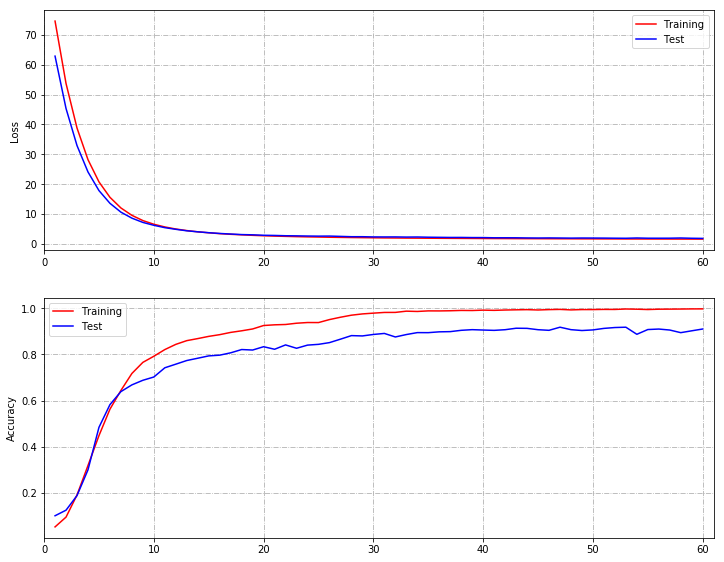

In [15]:
# plot training and validation history
hist = training_history.history
train_loss = hist["loss"]
test_loss = hist["val_loss"]
train_accuracy = hist["accuracy"]
test_accuracy = hist["val_accuracy"]
# train_top_3_accuracy = hist["top_3_accuracy"]
# test_top_3_accuracy = hist["val_top_3_accuracy"]

plt.figure(figsize=(12,15))
plt.subplot(3,1,1)
ax = plt.gca()
ax.set_xlim([0, len(train_loss) + 1])
plt.ylabel('Loss')
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Test')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(3,1,2)
ax = plt.gca()
ax.set_xlim([0, len(train_accuracy) + 1])
plt.ylabel('Accuracy')
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'r', label='Training')
plt.plot(range(1, len(test_accuracy)+1), test_accuracy, 'b', label='Test')
ax.grid(linestyle='-.')
plt.legend()
# plt.subplot(3,1,3)
# ax = plt.gca()
# ax.set_xlim([0, len(train_top_3_accuracy) + 1])
# plt.ylabel('Top-3 Accuracy')
# plt.plot(range(1, len(train_top_3_accuracy)+1), train_top_3_accuracy, 'r', label='Training')
# plt.plot(range(1, len(test_top_3_accuracy)+1), test_top_3_accuracy , 'b', label='Test')
# ax.grid(linestyle='-.')
# plt.legend()
plt.savefig(os.path.join(logdir, 'training_hist.png'))

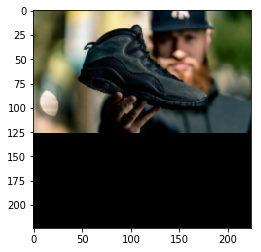

In [16]:
# def img_preprocessing(path):
#     img = load_and_preprocess_image(path)
#     img, _ = change_range(img,label=0)
#     return img

def img_preprocessing(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image/255  # normalize to [0,1] range
    image = tf.image.resize_with_pad(image,224,224)
    image, _ = change_range(image,label=0)
    return image

test_df = pd.read_csv("test_df.csv")
test_image_paths = test_df.loc[:, "Image_File"].tolist()
test_image_labels = test_df.loc[:, "Label"].tolist()

rand_indx = random.randint(0, len(test_image_paths)-1)
img = img_preprocessing(test_image_paths[rand_indx]) 
plt.imshow((img+1)/2)

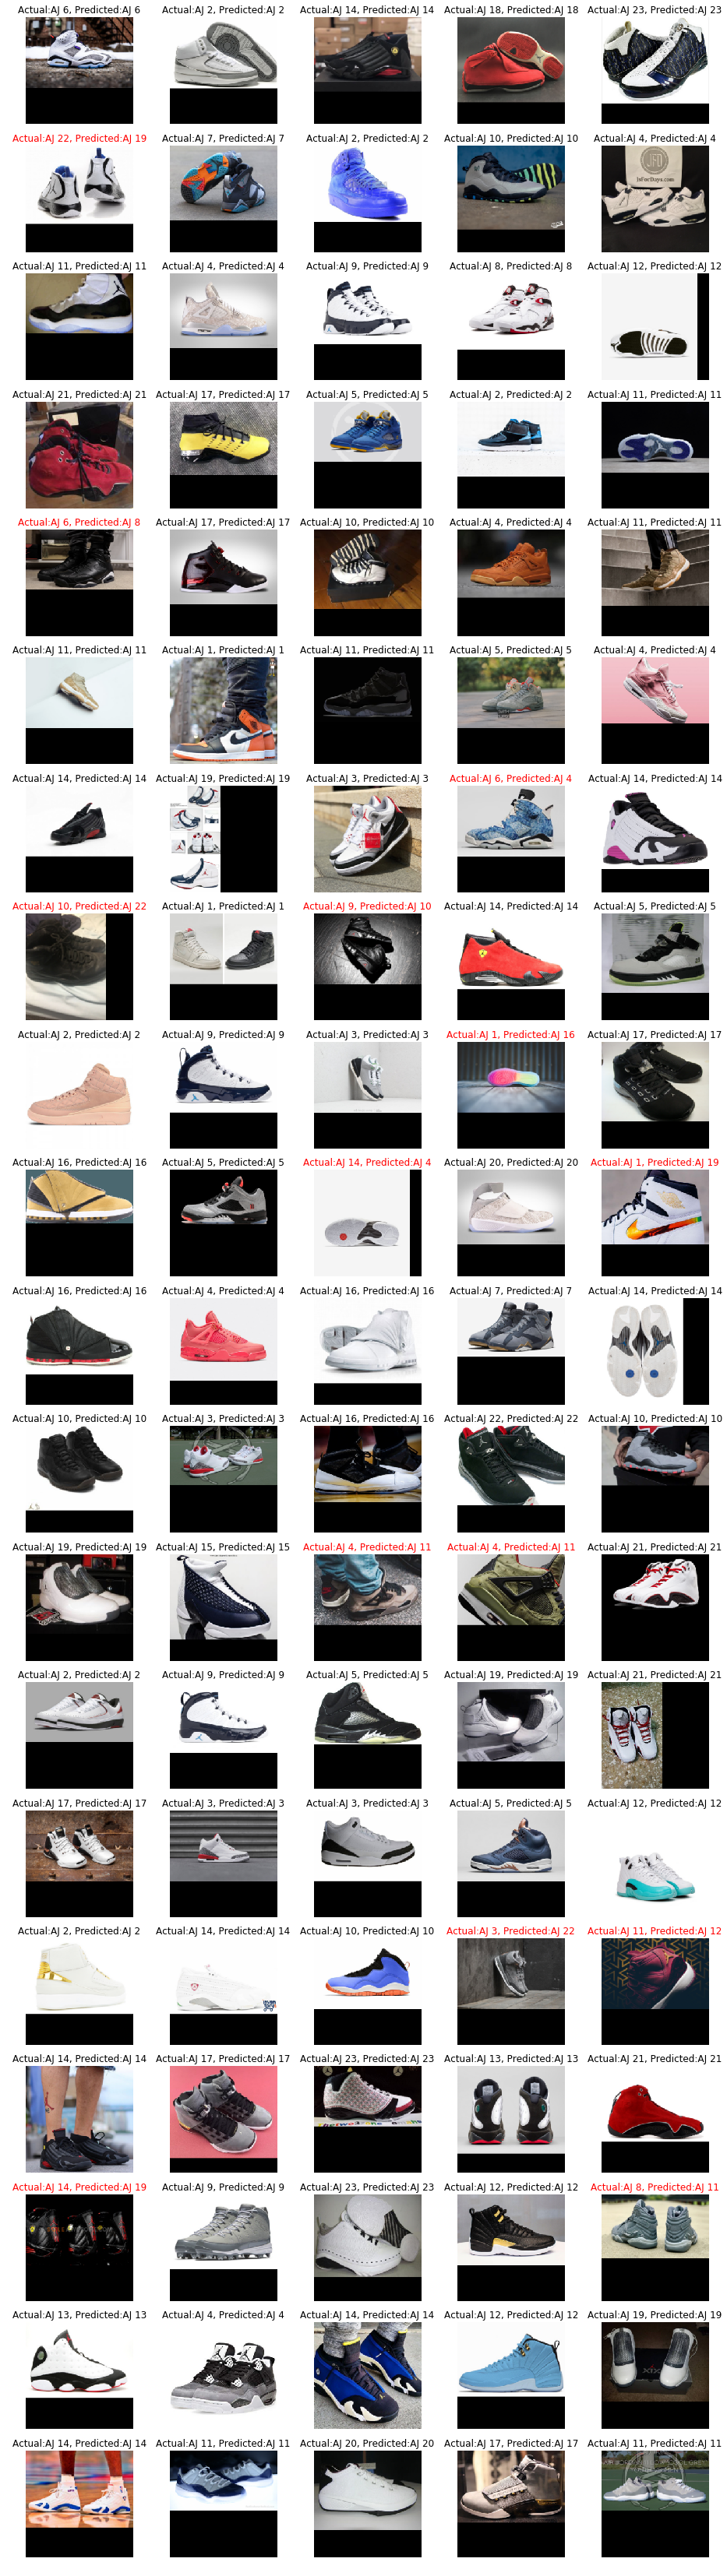

In [17]:
num_images=100
classes = ["AJ "+str(i) for i in range(1,24)]
indices = np.random.choice(len(test_image_paths), num_images, replace=False)
inputs = np.empty(shape=(num_images,224,224,3))
targets = np.empty(shape=(num_images))
for i, indx in enumerate(indices):
    inputs[i,:,:,:] = img_preprocessing(test_image_paths[indx]).numpy()
    targets[i] = test_image_labels[indx]
output = model.predict(inputs)
prediction = output.argmax(axis=1)
targets = targets.astype(int)
# output.shape
# output.argmax(axis=1)==targets

images_so_far = 0
fig = plt.figure(figsize=(16,3*num_images/5))
# fig = plt.figure(figsize=(16,8))
for i in range(num_images):
    images_so_far += 1
    ax = plt.subplot(num_images//5, 5, images_so_far)
    ax.axis('off')
    ax.set_title('Actual:{}, Predicted:{}'.format(classes[targets[i]], classes[prediction[i]]),
    color = 'k' if targets[i]==prediction[i] else 'r' )
    plt.imshow((inputs[i,:,:,:]+1)/2)  # need to transform range from [-1,1] to [0,1]

plt.savefig(os.path.join(logdir, 'example_output.png'))

[[52  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 41  1  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  1  1  0]
 [ 1  0 52  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  1 56  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0]
 [ 0  0  2  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0 40  0  1  0  0  0  0  1  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  1  0  0  0 44  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0 34  0  0  3  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  2  0  0  0  0  0  0 45  1  1  1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 37  3  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0 45  4  0  0  1  0  0  0  1  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  1  0 49  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0  2  0 48  0  1  1  0  2  0  1

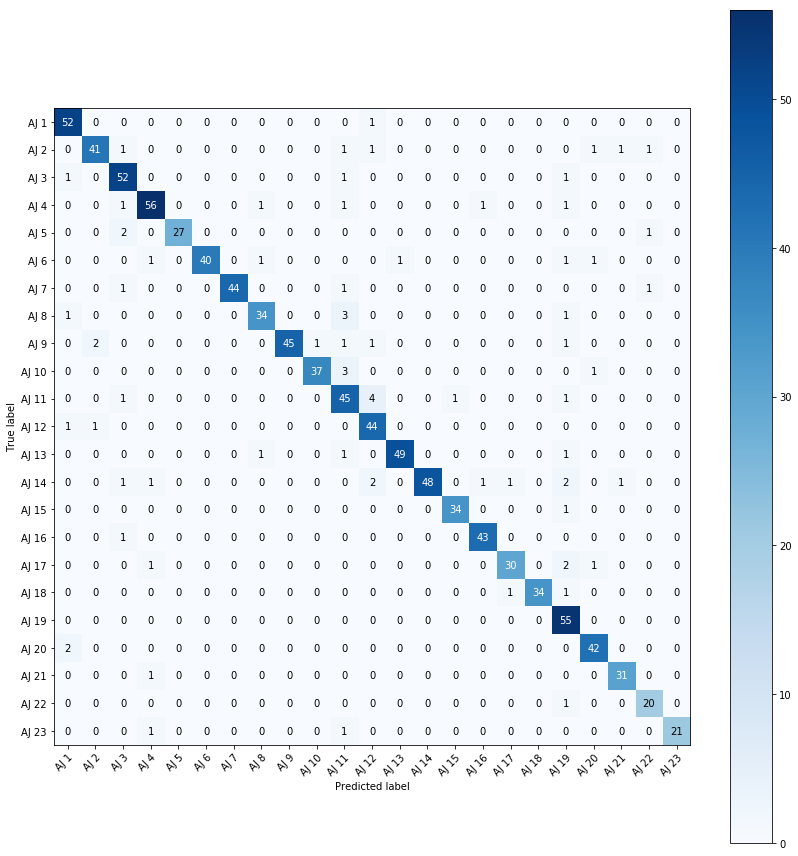

In [18]:
# plot the confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix

num_images=1000
classes = ["AJ "+str(i) for i in range(1,24)]
indices = np.random.choice(len(test_image_paths), num_images, replace=False)
inputs = np.empty(shape=(num_images,224,224,3))
targets = np.empty(shape=(num_images))
for i, indx in enumerate(indices):
    inputs[i,:,:,:] = img_preprocessing(test_image_paths[indx]).numpy()
    targets[i] = test_image_labels[indx]
output = model.predict(inputs)
prediction = output.argmax(axis=1)
    
cm = confusion_matrix(targets, prediction)
print(cm)
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

plt.savefig(os.path.join(logdir, 'confusion_matrix.png'))

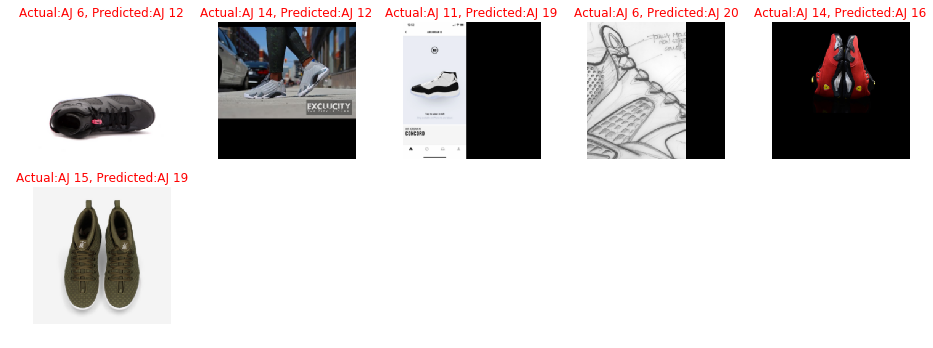

In [19]:
# check both train and test dataset - ONly PLOT THE WRONGLY CLASSIFIED ONES
def img_preprocessing(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image/255  # normalize to [0,1] range
    image = tf.image.resize_with_pad(image,224,224)
    image, _ = change_range(image,label=0)
    return image

check_df = pd.read_csv("dataset_df.csv")
check_image_paths = test_df.loc[:, "Image_File"].tolist()
check_image_labels = test_df.loc[:, "Label"].tolist()

num_images=100
classes = ["AJ "+str(i) for i in range(1,24)]
indices = np.random.choice(len(check_image_paths), num_images, replace=False)
inputs = np.empty(shape=(num_images,224,224,3))
targets = np.empty(shape=(num_images))
for i, indx in enumerate(indices):
    inputs[i,:,:,:] = img_preprocessing(check_image_paths[indx]).numpy()
    targets[i] = check_image_labels[indx]
output = model.predict(inputs)
prediction = output.argmax(axis=1)
targets = targets.astype(int)
# output.shape
# output.argmax(axis=1)==targets

images_so_far = 0
fig = plt.figure(figsize=(16,3*num_images/5))
wrong_image_paths=[]
for i in range(num_images):
    if targets[i]!=prediction[i]:
        wrong_image_paths.append(check_image_paths[indices[i]])
        images_so_far += 1
        ax = plt.subplot(num_images//5, 5, images_so_far)
        ax.axis('off')
        ax.set_title('Actual:{}, Predicted:{}'.format(classes[targets[i]], classes[prediction[i]]),
        color = 'k' if targets[i]==prediction[i] else 'r' )
        plt.imshow((inputs[i,:,:,:]+1)/2)  # need to transform range from [-1,1] to [0,1]

In [20]:
to_del = wrong_image_paths[7]
to_del

IndexError: list index out of range

In [ ]:
# os.remove(to_del)

In [21]:
test_input = img_preprocessing("screened_data/air_jordan_1/air_jordan_1_270.png")
test_input = np.expand_dims(test_input, axis=0)
logits = model.predict(test_input)
np.exp(logits) / np.sum(np.exp(logits), axis=1)

array([[8.7334573e-01, 1.9421553e-02, 7.2623976e-04, 4.6874755e-03,
        7.2623976e-04, 7.2623976e-04, 7.2623976e-04, 9.7162817e-03,
        2.9114720e-03, 7.2623976e-04, 3.8094877e-03, 7.2623976e-04,
        8.3592330e-04, 1.8066546e-03, 3.4118267e-03, 6.0203876e-03,
        1.9359866e-02, 7.2623976e-04, 2.3257306e-03, 2.2893388e-02,
        2.2918057e-02, 7.2623976e-04, 7.2623976e-04]], dtype=float32)